## Univariate Statistics and the SME

Yesterday, we learned how to extract measures of spectral power from EEG signals. Today, we're going to extend that work by analyzing **how spectral power correlates with cognitive, behavioral, or physiological variables** of interest. This is the core of almost any analysis you'll carry out in the Computational Memory Lab. 

The statistical approach we'll use today will be mostly straightforward T-tests to assess differences between normal distributions of power values. In particular, we'll focus on the contrast between power during successfully-encoded versus forgotten words. You'll see this called the **Subsequent Memory Effect** (SME) in the literature. In general, you can take an SME-style approach to any physiological variable.  

The basic analysis scheme is as follows: 

1. Extract spectral power for all encoding events (e.g. wavelet transform)
2. Normalize spectral power for each experimental session
3. Use a 2-sample T-test to compare distributions of power between remembered and not-remembered items
4. *Optional:* Average results into time windows or frequency bands of interest. 
5. Repeat for each subject in the dataset.

Let's get to work!

In [1]:
#First, let's use our tried-and-true code for loading R1001P's metadata
from cmlreaders import CMLReader, get_data_index
import numpy as np

#The "r1" database corresponds to all of the RAM subjects
df = get_data_index("r1")

#Specify which subject and experiment we want
sub = 'R1001P'
exp = 'FR1'

#Find out the sessions, localization, and montage for this subject
sessions = list(df[(df['subject']==sub) & (df['experiment']==exp)]['session'])
mont = int(df[(df['subject']==sub) & (df['experiment']==exp)].iloc()[0]['montage'])      #note that *usually* mont and loc will be 0.
loc = int(df[(df['subject']==sub) & (df['experiment']==exp)].iloc()[0]['localization'])

In [7]:
#Instead of just looking at session 1, we want to analyze data from all sessions. To do that, we'll use a for loop.

recalled = []  #for storing encoding success
sess_pows = []  #for storing our computed spectral powers

for sess in sessions:
    
    #Load session i events and elecs
    reader = CMLReader(sub, exp, sess, montage=mont, localization=loc)
    evs = reader.load('events')
    pairs = reader.load('pairs')
    
    #We only want to analyze word encoding events
    word_evs = evs.query('type == "WORD"')    #could also have written word_evs = evs[evs['type']=='WORD']
    
    #Grab some EEG and convert to MNE/PTSA (for this example, let's use PTSA)
    buf = 1000  #to remove edge effects during wavelet convolution
    eeg = reader.load_eeg(events=word_evs, rel_start=-1*buf, rel_stop=1600+buf, scheme=pairs)
    eeg_ptsa = eeg.to_ptsa()
    
    from ptsa.data.filters import ButterworthFilter
    from ptsa.data.filters import MorletWaveletFilter
    
    sr = eeg.samplerate
    
    #Filter out line noise
    freq_range = [58., 62.]
    b_filter = ButterworthFilter(timeseries=eeg_ptsa, freq_range=freq_range, filt_type='stop', order=4)
    eeg_filtered = b_filter.filter()
    
    #Get spectral power
    myfreqs = np.logspace(np.log10(3), np.log10(170), 20)  #let's start with 3-170 Hz, 20 frequencies
    wf = MorletWaveletFilter(timeseries=eeg_filtered, freqs=myfreqs, width=5, output='power')
    pow_wavelet = wf.filter()   #output is freqs, events, elecs, and time
    pows = pow_wavelet.data[:, :, :, int((buf/1000.)*sr):-1*int((buf/1000.)*sr)]  #remove buffer period
    pows = np.log10(pows)
    
    #Reshape array to average into 100 ms bins
    samps = int(sr/10.)  #samples per window
    numwins = int(pows.shape[3]/samps)
    reshaped_arr = np.reshape(pows[:, :, :, :samps*numwins], (pows.shape[0], pows.shape[1], pows.shape[2], numwins, samps))
    avg_pows = np.mean(reshaped_arr, axis=4)

    from scipy.stats import zscore
    z_pows = zscore(avg_pows, axis=1)  #z-score power values across events (important to do within-session)
    sess_pows.append(z_pows)

    recalled.extend(list(word_evs['recalled'])) # we need to store this data across-sessions

    print(str(sess)+' completed successfully!')    

/home1/esolo/anaconda3/envs/CML/lib/python3.6/site-packages/cmlreaders/path_finder.py:238: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1001P/experiments/FR1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1001P/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  14.142930746078491
0 completed successfully!


/home1/esolo/anaconda3/envs/CML/lib/python3.6/site-packages/cmlreaders/path_finder.py:238: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1001P/experiments/FR1/sessions/1/ephys/current_processed/sources.json
/data/eeg/R1001P/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


CPP total time wavelet loop:  14.395814180374146
1 completed successfully!


Let's unpack what just happened up there: 

```
#Load session i events and elecs
reader = CMLReader(sub, exp, sess, montage=mont, localization=loc)
evs = reader.load('events')
pairs = reader.load('pairs')

#We only want to analyze word encoding events
word_evs = evs.query('type == "WORD"')    #could also have written word_evs = evs[evs['type']=='WORD']
```

You should be pretty used to this syntax by now; this is just how we load CML event and electrode information from a given subject, experiment, and session. We filtered our events dataframe for only the **word encoding events**.

```
#Grab some EEG and convert to MNE/PTSA (for this example, let's use PTSA)
buf = 1000  #to remove edge effects during wavelet convolution
eeg = reader.load_eeg(events=word_evs, rel_start=-1*buf, rel_stop=1600+buf, scheme=pairs)
eeg_ptsa = eeg.to_ptsa()
```

Also the same as last time! We're loading the 1600 ms that correspond to the word presentation interval for each word event, and we're adding **1 second buffers** to account for edge effects of our wavelet filter.

```
#Filter out line noise
freq_range = [58., 62.]
b_filter = ButterworthFilter(timeseries=eeg_ptsa, freq_range=freq_range, filt_type='stop', order=4)
eeg_filtered = b_filter.filter()
```

This is our standard stop-band filter to remove the effects of 60 Hz line noise. We could also have applied one to the 120 Hz harmonic, but typically that's less of an issue.

```
#Get spectral power
myfreqs = np.logspace(np.log10(3), np.log10(170), 20)  #let's start with 3-170 Hz, 20 frequencies
wf = MorletWaveletFilter(timeseries=eeg_filtered, freqs=myfreqs, width=5, output='power')
pow_wavelet = wf.filter()   #output is freqs, events, elecs, and time
pows = pow_wavelet.data[:, :, :, int((buf/1000.)*sr):-1*int((buf/1000.)*sr)]  #remove buffer period
pows = np.log10(pows)
```

The meat of the analysis! We defined our desired frequencies (note that they're **log spaced** since a wavelet is less sensitive to differences at higher frequencies), created a wavelet filter object, ran the convolution, removed the buffer period, and took the log transform. 

```
#Reshape array to average into 100 ms bins
samps = int(sr/10.)  #samples per window
numwins = int(pows.shape[3]/samps)
reshaped_arr = np.reshape(pows[:, :, :, :samps*numwins], (pows.shape[0], pows.shape[1], pows.shape[2], numwins, samps))
avg_pows = np.mean(reshaped_arr, axis=4)
```

This is new, and technically optional. Here, we're averaging spectral power into 16 100 ms bins that span the entire 1.6 second interval. It's effectively a **data-smoothing technique**. You'll find spectral analyses to often involve some type of temporal windowing, which is important because the precise timing of effects differs somewhat between electrodes, brain regions, and subjects. Averaging into reasonable windows of interest removes some of that variability and let's the true signal come through. There's no "right" choice for your windows, but I find that nonoverlapping 100-200 ms works well for these types of data. (And it's really only important for the high frequencies, since the wavelet already smoothed our low-frequency signals). 

```
from scipy.stats import zscore
z_pows = zscore(avg_pows, axis=1)  #z-score power values across events (important to do within-session)
sess_pows.append(z_pows)
```

Finally, our last step is to **z-score, or normalize, the power values** across events but within each experimental session. Why? Properties of the recording hardware can change from session-to-session, yielding power values that may fall in entirely different ranges from one day to the next. If we averaged these raw values together, we'd get an innaccurate read of the underlying neural signals. We can account for this by z-scoring the power across all the events in each session. Be sure you're z-scoring across events and not some other dimension!

In [9]:
#Now let's compute some statistics!
from scipy.stats import ttest_ind  #this is our 2-sample t-test

recalled = np.array(recalled)
all_pows = np.concatenate(sess_pows, axis=1)

print(recalled.shape)
print(all_pows.shape)  #dimensions are freqs, events, elecs, and time bins

(600,)
(20, 600, 72, 16)


In [11]:
#Compare remembered vs. not-remembered (final output in shape [freqs, elecs, time])
tstats, pvals = ttest_ind(all_pows[:, recalled==1, :, :], all_pows[:, recalled==0, :, :], equal_var=False, axis=1)  #equal_var=False applies Welch's t-test, which assumes unequal population variances

fusiform


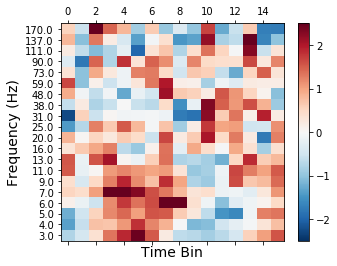

In [90]:
#Visualize results for one electrode
%matplotlib inline
from pylab import *

#Electrode 7 shows a classic tilt response, electrode 4 shows a theta response
elec = 59
figure(figsize=(5, 4)); ax=subplot(111)
matshow(tstats[:, elec, :], fignum=0, cmap='RdBu_r', aspect='auto', vmin=-2.5, vmax=2.5)
yticks(np.arange(len(myfreqs)), np.round(myfreqs))
ax.invert_yaxis()
xlabel('Time Bin', fontsize=14); ylabel('Frequency (Hz)', fontsize=14)
colorbar();

print(pairs.iloc()[elec]['ind.region'])

Text(0,0.5,'Count')

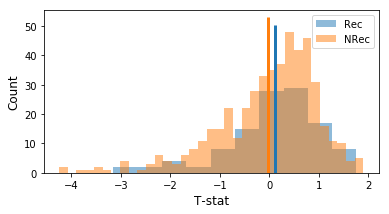

In [96]:
#Let's take a look at exactly what we were comparing by drilling down into one of the pixels from the plot above
freq_idx = 0
time_idx = 3

rec_pows = all_pows[freq_idx, recalled==1, elec, time_idx]
nrec_pows = all_pows[freq_idx, recalled==0, elec, time_idx]

figure(figsize=(6, 3)); ax=subplot(111)
hist(rec_pows, alpha=0.5, label='Rec');
hist(nrec_pows, 35, alpha=0.5, label='NRec')
legend()
vlines(np.mean(rec_pows), ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], color='C0', linewidth=3)
vlines(np.mean(nrec_pows), ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], color='C1', linewidth=3)
xlabel('T-stat', fontsize=12); ylabel('Count', fontsize=12)

parstriangularis


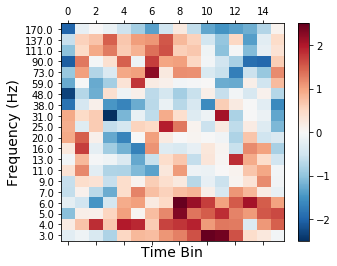

In [55]:
#Electrode 7 shows a classic tilt response, electrode 4 shows a theta response
elec = 4
figure(figsize=(5, 4)); ax=subplot(111)
matshow(tstats[:, elec, :], fignum=0, cmap='RdBu_r', aspect='auto', vmin=-2.5, vmax=2.5)
yticks(np.arange(len(myfreqs)), np.round(myfreqs))
ax.invert_yaxis()
xlabel('Time Bin', fontsize=14); ylabel('Frequency (Hz)', fontsize=14)
colorbar();

print(pairs.iloc()[elec]['ind.region'])

**Exercise: Compute the SME for all electrodes in R1002P, and plot time-frequency spectrograms averaged across hippocampal electrodes**

**Exercise: Compute the SME for all electrodes in R1001P using MNE**